# Web Crawling

#### 웹 크롤링 방법

**웹 페이지의 종류**
- Static Page : 웹 브라우저에 화면이 한 번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지
- Dynamic Page : 웹 브라우저에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

**Requests 이용**
- 받아오는 문자열에 따라 구분
    - json 문자열 파싱 : Dynamic Page Crawling 할 때 주로
    - html 문자열 파싱 : Static Page Crawling 할 때 주로

**Selenium 이용**
- 브라우저를 직접 열어서 데이터를 받는 방법

# Crawling Naver Stock Datas

- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율 데이터
- 수집 절차
    - 웹서비스 분석 -> url
    - 서버에 데이터 요청 : request(url) -> response:json(str)
    - 서버에서 받은 데이터 파싱 : json(str) > list, dict > DataFrame

In [1]:
import warnings
import requests
import pandas as pd

warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats={'png', 'retina'}

**1. 웹서비스 분석**

In [2]:
page, page_size = 1, 60
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}'
print(url)

https://m.stock.naver.com/api/index/KOSPI/price?pageSize=60&page=1


**2. 서버에 데이터 요청**

In [3]:
response = requests.get(url)
response

<Response [200]>

**3. 서버에서 받은 데이터 파싱**

In [4]:
kospi_df = pd.DataFrame(response.json())[['localTradedAt', 'closePrice']]
kospi_df.tail()

,localTradedAt,closePrice
55,2023-06-15,"2,608.54"
56,2023-06-14,"2,619.08"
57,2023-06-13,"2,637.95"
58,2023-06-12,"2,629.35"
59,2023-06-09,"2,641.16"


**4. 함수로 만들기**

In [5]:
def stock_crawling(code='KOSPI', page=1, pagesize=60):
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}'
    response = requests.get(url)
    df = pd.DataFrame(response.json())[['localTradedAt', 'closePrice']]

    return df

In [6]:
kospi_df = stock_crawling()
kospi_df.tail()

,localTradedAt,closePrice
55,2023-06-15,"2,608.54"
56,2023-06-14,"2,619.08"
57,2023-06-13,"2,637.95"
58,2023-06-12,"2,629.35"
59,2023-06-09,"2,641.16"


In [7]:
kosdaq_df = stock_crawling(code='KOSDAQ')
kosdaq_df.tail()

,localTradedAt,closePrice
55,2023-06-15,878.04
56,2023-06-14,871.83
57,2023-06-13,896.81
58,2023-06-12,885.76
59,2023-06-09,883.71


**5. 원달러 환율 데이터 수집 : 실습**

In [8]:
page, pagesize = 1, 60

url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&reutersCode=FX_USDKRW&pageSize={pagesize}'
response = requests.get(url)
USD_df = pd.DataFrame(response.json()['result'])[['localTradedAt', 'closePrice']]
USD_df.tail()

,localTradedAt,closePrice
55,2023-06-15,"1,277.00"
56,2023-06-14,"1,275.00"
57,2023-06-13,"1,272.00"
58,2023-06-12,"1,290.00"
59,2023-06-09,"1,293.50"


In [9]:
len(kospi_df), len(kosdaq_df), len(USD_df)

(60, 60, 60)

**6. 시각화**

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# 전처리
df = kospi_df.copy()
df.columns = ['date', 'kospi']
df['kospi'] = df['kospi'].apply(lambda data:float(data.replace(',', '')))
df['kosdaq'] = kosdaq_df['closePrice'].apply(lambda data:float(data.replace(',', '')))
df['USD'] = USD_df['closePrice'].apply(lambda data:float(data.replace(',', '')))

df.tail()

,date,kospi,kosdaq,USD
55,2023-06-15,2608.54,878.04,1277.0
56,2023-06-14,2619.08,871.83,1275.0
57,2023-06-13,2637.95,896.81,1272.0
58,2023-06-12,2629.35,885.76,1290.0
59,2023-06-09,2641.16,883.71,1293.5


In [12]:
df.dtypes

date       object
kospi     float64
kosdaq    float64
USD       float64
dtype: object

In [13]:
df['date'][::5]

0     2023-09-01
5     2023-08-25
10    2023-08-18
15    2023-08-10
20    2023-08-03
25    2023-07-27
30    2023-07-20
35    2023-07-13
40    2023-07-06
45    2023-06-29
50    2023-06-22
55    2023-06-15
Name: date, dtype: object

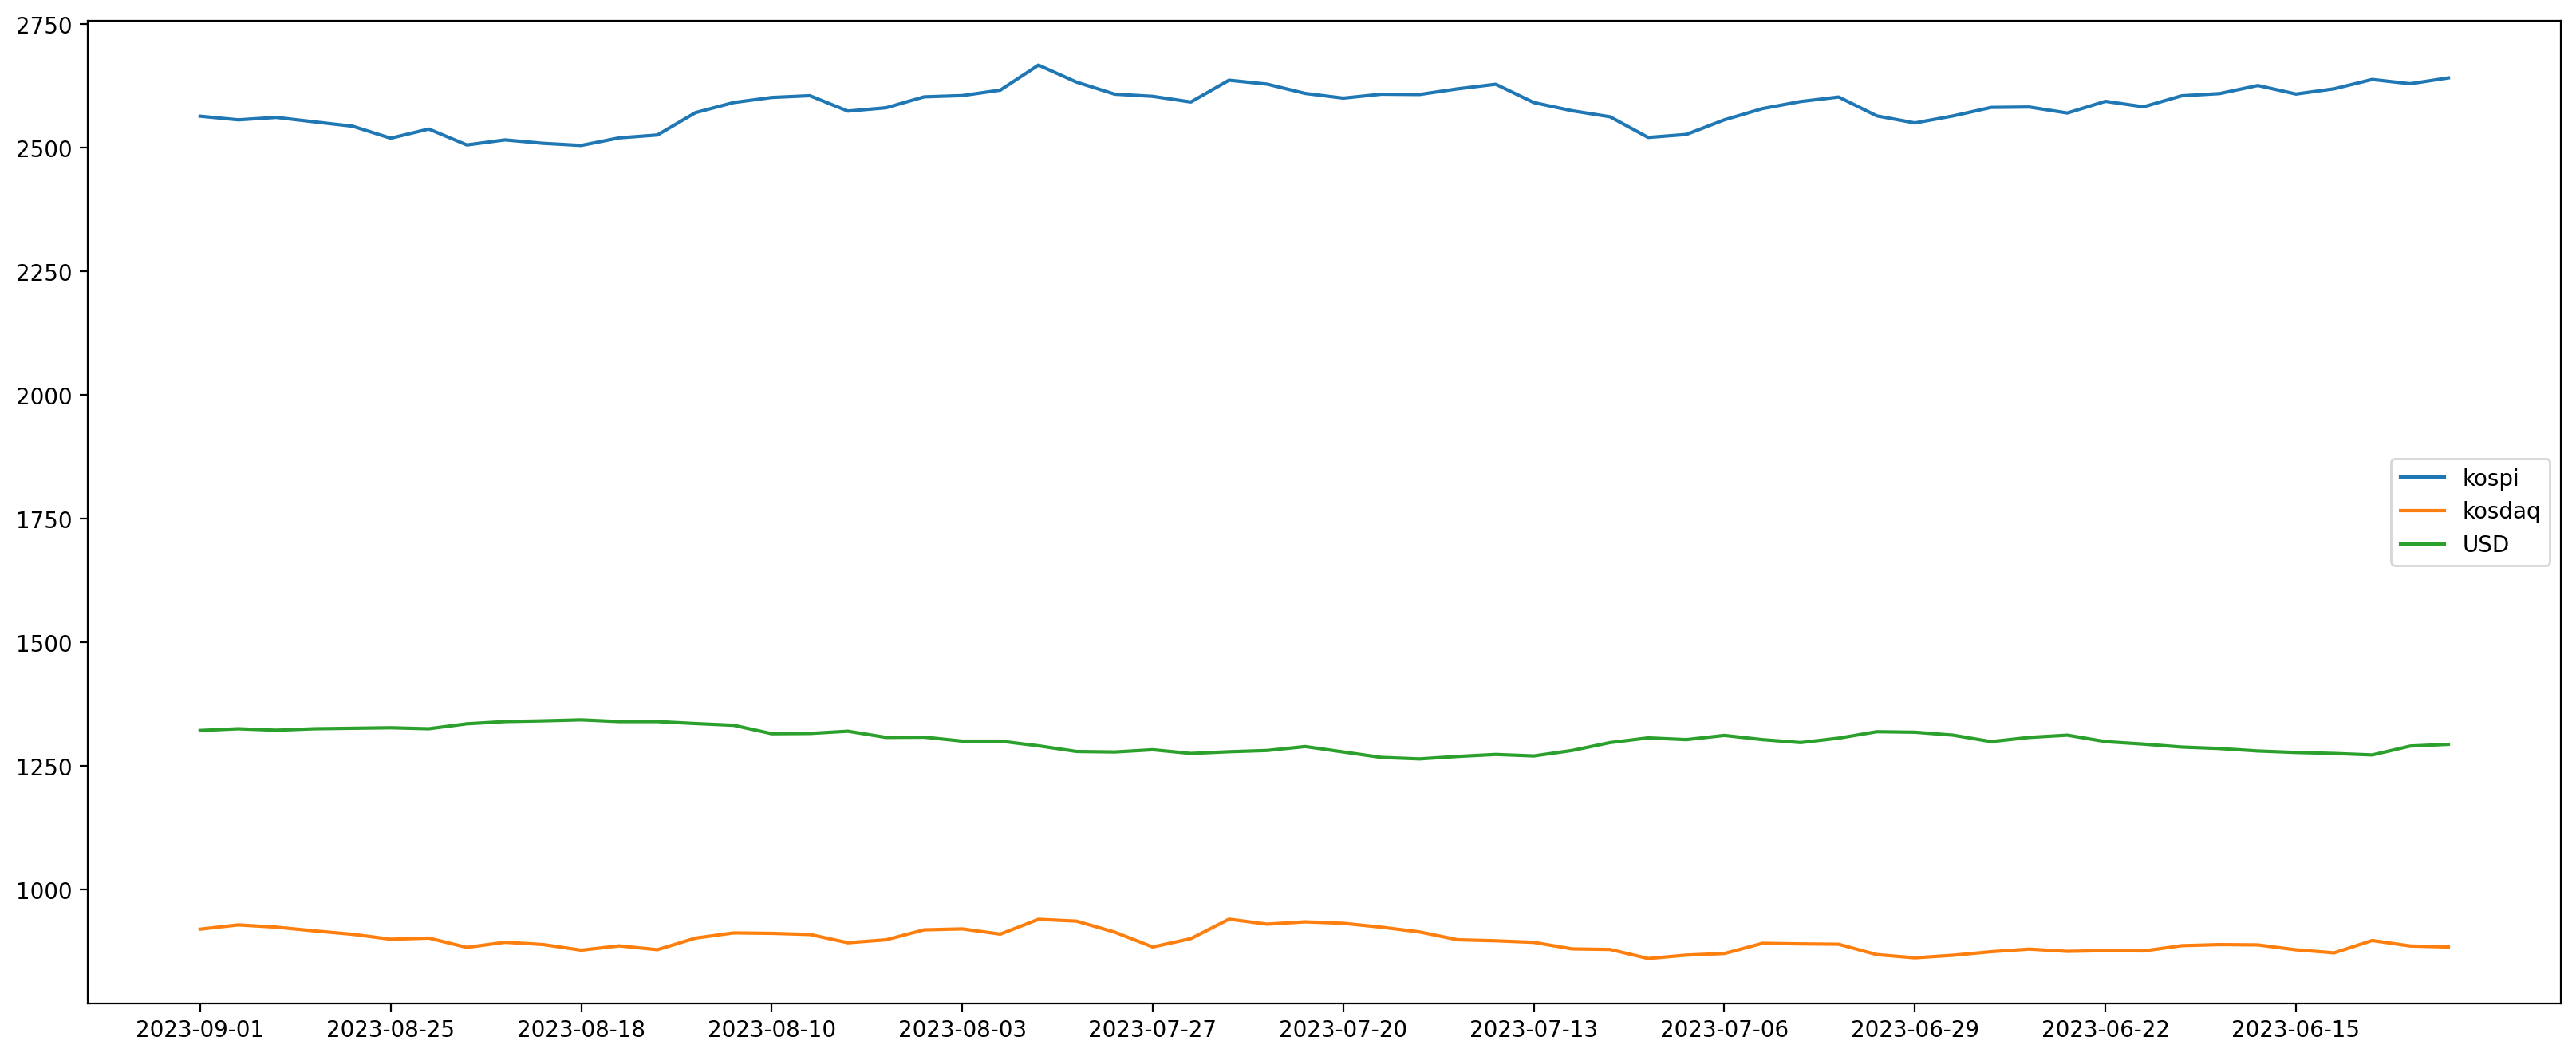

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(df['date'], df['kospi'], label='kospi')
plt.plot(df['date'], df['kosdaq'], label='kosdaq')
plt.plot(df['date'], df['USD'], label='USD')
plt.xticks(df['date'][::5])
plt.legend()
plt.show()

**7. 데이터 스케일링**

In [19]:
from sklearn.preprocessing import minmax_scale

print(minmax_scale(df['kospi']))

[0.36421234 0.31844744 0.34889586 0.29316602 0.23934305 0.09005352
 0.2040967  0.0061512  0.06913945 0.02645014 0.         0.09442086
 0.13003629 0.40825491 0.5336778  0.59703512 0.61893338 0.42738513
 0.46878268 0.60466261 0.62059421 0.68874946 1.         0.78784524
 0.63861721 0.61087532 0.54044412 0.81171188 0.76293289 0.64747493
 0.58885403 0.63812512 0.63431137 0.70431199 0.76151812 0.53349326
 0.43193701 0.35670788 0.09964938 0.13661807 0.31857046 0.45826413
 0.54628775 0.60263271 0.36771852 0.28000246 0.36716491 0.47296549
 0.47794796 0.40351848 0.54868672 0.48059298 0.61764163 0.64587562
 0.74607861 0.63997047 0.70480408 0.82087716 0.76797687 0.8406225 ]


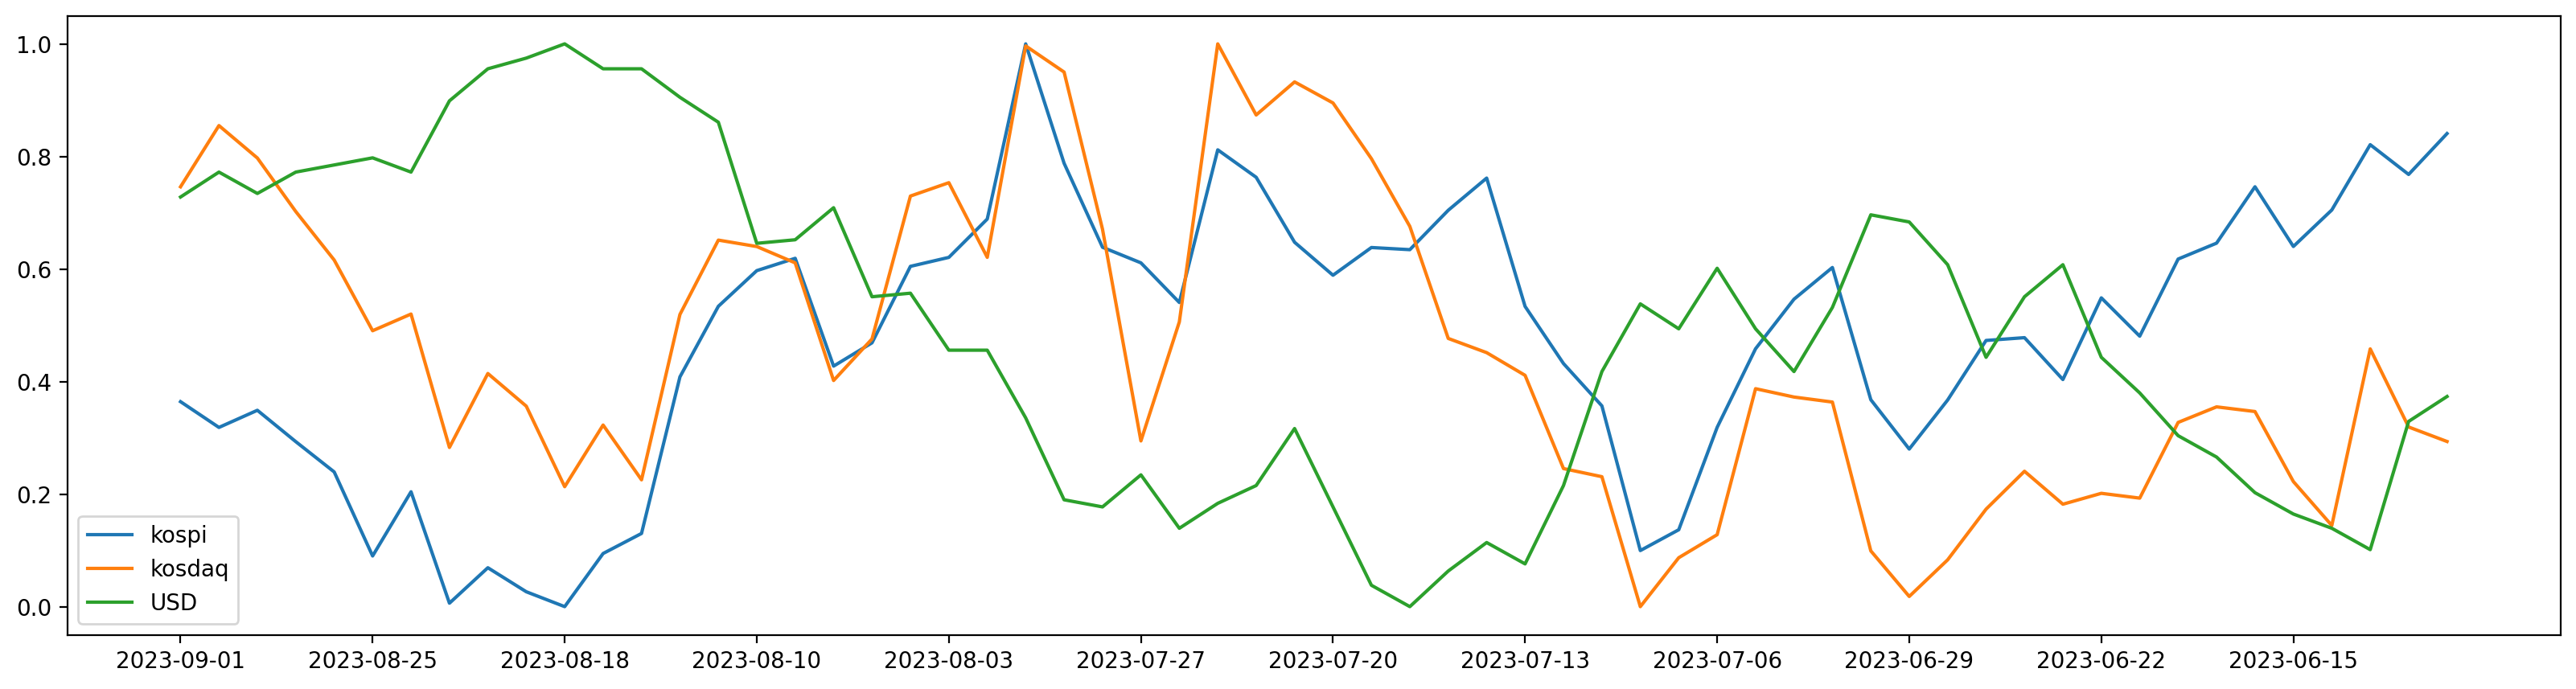

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'], minmax_scale(df['kospi']), label='kospi')
plt.plot(df['date'], minmax_scale(df['kosdaq']), label='kosdaq')
plt.plot(df['date'], minmax_scale(df['USD']), label='USD')
plt.xticks(df['date'][::5])
plt.legend()
plt.show()

**8. 상관관계 분석**

In [21]:
import scipy.stats as spst

In [22]:
df.corr()

,kospi,kosdaq,USD
kospi,1.000000,0.412575,-0.776491
kosdaq,0.412575,1.000000,-0.175002
USD,-0.776491,-0.175002,1.000000
